# Estimating a gravity model of international trade *(WIP)*

## Table of Contents

* Introduction
* Initialize and configure Spark
* Load and prepare data
    * Distances
    * Geography
    * GDP
    * Trade flows
    * Combine everything into one dataset
* Estimate gravity equation
* ...

## Introduction: Gravity model

* Inspired by the gravity equation from physics, for objects with mass
* Idea: 
    * Two large countries (with high "mass") attract each other = trade more with each other
    * Distant countries trade less with each other. Different distance metrics: Geographical (kilometers between capital or center of economic activity, common border, landlocked, etc) and cultural (common language, common culture e.g. colonized by the same country etc)

https://en.wikipedia.org/wiki/Gravity_model_of_trade

Basic gravity model: 

$$ F_{ij}=G * \frac{M_i * M_j}{D_{ij}} * \eta_{ij} $$

* *F(ij)*: trade volume between countries i and j
* *G*: constant
* *M(i)*: GDP of country i ("mass")
* *M(j)*: GDP of country j ("mass")
* *D(ij)*: distance between countries i and j
* *eta(ij)*: error of each country i,j pair

Which can be transformed into the the following log-log regression equation with error epsilon(ij):

$$ ln(F_{ij}) = \beta_0 + \beta_1ln(M_i) + \beta_2ln(M_j) + \beta_3ln(D_{ij}) + \varepsilon_{ij} $$

## Imports

In [37]:
# Initialization and configuration
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession

# Spark
from pyspark.sql.types import *
import pyspark.sql.functions as F

# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Initialize and configure Spark

In [3]:
# Configuration
conf = SparkConf().setAppName("Gravity").setMaster("local[4]")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g") 
conf.set("spark.executor.pyspark.memory", "2g")

# Initialization
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
spark = SparkSession(sc)

<b>Spark web UI:</b> http://localhost:4040/

## Load and prepare data

* annual data
* sample: years 2014-2018

### Flows

In [175]:
flows = spark.read.parquet("data/parquet/*")
# flows = spark.read.parquet("data/parquet/full2018.parquet")

flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter((flows["YEAR"] >= 2014) & (flows["YEAR"] <= 2018)) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "YEAR").agg({"VALUE_IN_EUROS": "sum"}) \

flows = flows \
    .withColumn("TRADE_VOLUME", flows["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)") \
    .fillna({"TRADE_VOLUME": 0}) \
    .cache()

In [176]:
flows.printSchema()

root
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE_VOLUME: double (nullable = false)



In [177]:
flows.count()

31151

In [178]:
flows.distinct().count()

31151

In [179]:
flows.show(10)

+------------+-----------+----------+----+------------+
|REPORTER_ISO|PARTNER_ISO|TRADE_TYPE|YEAR|TRADE_VOLUME|
+------------+-----------+----------+----+------------+
|          NL|         MK|         E|2014|  140.318079|
|          DE|         HN|         E|2014|   433.83564|
|          DE|         AR|         E|2014| 3686.134307|
|          IT|         CG|         E|2014|  965.454652|
|          IT|         US|         E|2014|42101.902882|
|          IT|         CX|         E|2014|    0.019411|
|          GB|         NO|         E|2014|25014.442744|
|          DK|         AZ|         E|2014|   33.826639|
|          DK|         HT|         E|2014|    1.751629|
|          ES|         IE|         I|2014| 4331.333932|
+------------+-----------+----------+----+------------+
only showing top 10 rows



### Distances

http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6


* meaning of other distance measures? distw, distwces?
* meaning of comcol, curcol, col45, smctry, etc?
* common currency?

* iso_o: 3d iso code of "origin"
* iso_d: 3d iso code of "destination"
* contig: contiguous border
* comlang_off: common official language
* dist: distance

In [180]:
distances = spark.read.csv("data/dist_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso_o", "iso_d", "contig", "comlang_off", "dist")

In [181]:
distances.printSchema()

root
 |-- iso_o: string (nullable = true)
 |-- iso_d: string (nullable = true)
 |-- contig: integer (nullable = true)
 |-- comlang_off: integer (nullable = true)
 |-- dist: double (nullable = true)



In [182]:
distances.count()

50176

In [183]:
distances.show(5)

+-----+-----+------+-----------+--------+
|iso_o|iso_d|contig|comlang_off|    dist|
+-----+-----+------+-----------+--------+
|  ABW|  ABW|     0|          0|5.225315|
|  ABW|  AFG|     0|          0|13257.81|
|  ABW|  AGO|     0|          0|9516.913|
|  ABW|  AIA|     0|          0|983.2682|
|  ABW|  ALB|     0|          0|9091.742|
+-----+-----+------+-----------+--------+
only showing top 5 rows



In [184]:
distances.filter(distances.dist.isNull()).count()

0

In [185]:
distances.filter(distances.contig.isNull()).count()

0

In [186]:
distances.filter(distances.comlang_off.isNull()).count()

0

### Geographies

* http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6
* .filter(geographies["maincity"] == 1)   # removes rows where there is a capital and a main city


In [187]:
geographies = spark.read.csv("data/geo_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso2", "iso3", "country", "landlocked", "maincity")
    
geographies = geographies \
    .filter(geographies["maincity"] == 1) \
    .drop("maincity")

In [188]:
geographies.printSchema()

root
 |-- iso2: string (nullable = true)
 |-- iso3: string (nullable = true)
 |-- country: string (nullable = true)
 |-- landlocked: integer (nullable = true)



In [189]:
geographies.count()

225

In [190]:
geographies.show(5)

+----+----+-----------+----------+
|iso2|iso3|    country|landlocked|
+----+----+-----------+----------+
|  AW| ABW|      Aruba|         0|
|  AF| AFG|Afghanistan|         1|
|  AO| AGO|     Angola|         0|
|  AI| AIA|   Anguilla|         0|
|  AL| ALB|    Albania|         0|
+----+----+-----------+----------+
only showing top 5 rows



### GDP

* in constant 2010 us dollars
* https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.KD&country=#

In [191]:
gdp = spark.read.csv("data/worldbank_gdp.csv", sep=",", header=True, inferSchema=True) \
    .select("Country Name", "Country Code", "Time", "Value")

In [192]:
gdp.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Value: double (nullable = true)



In [193]:
gdp.count()

2645

In [194]:
gdp.show(5)

+------------+------------+----+-------------------+
|Country Name|Country Code|Time|              Value|
+------------+------------+----+-------------------+
| Afghanistan|         AFG|2009|1.38651943147185E10|
| Afghanistan|         AFG|2010|1.58565747314411E10|
| Afghanistan|         AFG|2011|1.59241799977914E10|
| Afghanistan|         AFG|2012|1.79548771466564E10|
| Afghanistan|         AFG|2013|1.89604839698941E10|
+------------+------------+----+-------------------+
only showing top 5 rows



In [195]:
gdp.filter(gdp.Value.isNull()).count()

205

In [196]:
gdp = gdp.filter(gdp.Value.isNotNull())

In [197]:
gdp.filter(gdp.Value.isNull()).show()

+------------+------------+----+-----+
|Country Name|Country Code|Time|Value|
+------------+------------+----+-----+
+------------+------------+----+-----+



### Combine dataframes

In [198]:
# Flows: REPORTER_ISO, PARTNER_ISO - 2d
# Distances: iso_o, iso_d - 3d
# gdp: Country Code - 3d
# geographies: iso2, iso3

In [199]:
# flows
df = flows \
    .join(F.broadcast(geographies), flows["REPORTER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "REPORTER_ISO_3") \
    .withColumnRenamed("landlocked", "REPORTER_LANDLOCKED") \
    .drop("iso2", "country") \
    .join(F.broadcast(geographies), flows["PARTNER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "PARTNER_ISO_3") \
    .withColumnRenamed("landlocked", "PARTNER_LANDLOCKED") \
    .drop("iso2", "country")

df = df \
    .withColumn("LANDLOCKED_ANY", ((df["REPORTER_LANDLOCKED"] == 1) | (df["PARTNER_LANDLOCKED"] == 1)).cast(IntegerType()))

# gdp
df = df \
    .join(F.broadcast(gdp), (df["REPORTER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .drop("Country Name", "Country Code", "Time") \
    .withColumnRenamed("Value", "REPORTER_GDP") \
    .join(F.broadcast(gdp), (df["PARTNER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .drop("Country Name", "Country Code", "Time") \
    .withColumnRenamed("Value", "PARTNER_GDP")

# distance
df = df \
    .join(F.broadcast(distances), (df["REPORTER_ISO_3"] == distances["iso_o"]) & (df["PARTNER_ISO_3"] == distances["iso_d"]), how="inner") \
    .drop("iso_o", "iso_d") \
    .withColumnRenamed("dist", "DISTANCE")

df = df \
    .withColumn("REPORTER_GDP", df["REPORTER_GDP"]/1e6) \
    .withColumn("PARTNER_GDP", df["PARTNER_GDP"]/1e6)

df = df \
    .select(
        "REPORTER_ISO", "PARTNER_ISO", "YEAR", "TRADE_TYPE", "TRADE_VOLUME", "REPORTER_GDP", "PARTNER_GDP",
        "DISTANCE", "LANDLOCKED_ANY", "contig", "comlang_off") \
    .withColumnRenamed("contig", "COMMON_BORDER").withColumnRenamed("comlang_off", "COMMON_LANGUAGE")

data = df.cache()

In [200]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE
0,NL,MK,2014,E,140.318079,8.618161e+05,1.022170e+04,1694.944,1,0,0
1,DE,HN,2014,E,433.835640,3.654924e+06,1.801671e+04,9083.054,0,0,0
2,DE,AR,2014,E,3686.134307,3.654924e+06,4.437071e+05,11512.140,0,0,0
3,IT,CG,2014,E,965.454652,2.043486e+06,1.423810e+04,5140.217,0,0,0
4,IT,US,2014,E,42101.902882,2.043486e+06,1.624253e+07,6895.107,0,0,0


In [201]:
data.printSchema()

root
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- TRADE_VOLUME: double (nullable = false)
 |-- REPORTER_GDP: double (nullable = true)
 |-- PARTNER_GDP: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- LANDLOCKED_ANY: integer (nullable = true)
 |-- COMMON_BORDER: integer (nullable = true)
 |-- COMMON_LANGUAGE: integer (nullable = true)



In [202]:
data.count()

23635

In [203]:
data.filter(data.TRADE_VOLUME.isNull()).count()

0

In [204]:
data.filter(data.REPORTER_GDP.isNull()).count()

0

In [205]:
data.filter(data.PARTNER_GDP.isNull()).count()

0

In [206]:
data.filter(data.DISTANCE.isNull()).count()

0

## Data exploration

In [286]:
data.describe()

DataFrame[summary: string, REPORTER_ISO: string, PARTNER_ISO: string, YEAR: string, TRADE_TYPE: string, TRADE_VOLUME: string, REPORTER_GDP: string, PARTNER_GDP: string, DISTANCE: string, LANDLOCKED_ANY: string, COMMON_BORDER: string, COMMON_LANGUAGE: string, TRADE_VOLUME_log: string, REPORTER_GDP_log: string, PARTNER_GDP_log: string, DISTANCE_log: string]

In [288]:
data.summary()

DataFrame[summary: string, REPORTER_ISO: string, PARTNER_ISO: string, YEAR: string, TRADE_TYPE: string, TRADE_VOLUME: string, REPORTER_GDP: string, PARTNER_GDP: string, DISTANCE: string, LANDLOCKED_ANY: string, COMMON_BORDER: string, COMMON_LANGUAGE: string, TRADE_VOLUME_log: string, REPORTER_GDP_log: string, PARTNER_GDP_log: string, DISTANCE_log: string]

### Distributions

* Features should be transformed because the distributions are anything but normal. Here: Log transform applied because that's what's happening in the gravity model anyway

In [207]:
vizdf = data.select("REPORTER_ISO", "PARTNER_ISO", "YEAR", "TRADE_VOLUME", 
                    "REPORTER_GDP", "PARTNER_GDP", "DISTANCE").toPandas()

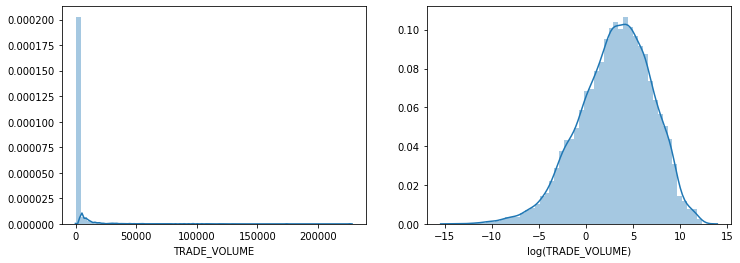

In [208]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(vizdf["TRADE_VOLUME"])
plt.xlabel("TRADE_VOLUME")
plt.subplot(1,2,2)
sns.distplot(vizdf["TRADE_VOLUME"].apply(np.log))
plt.xlabel("log(TRADE_VOLUME)")
plt.show()

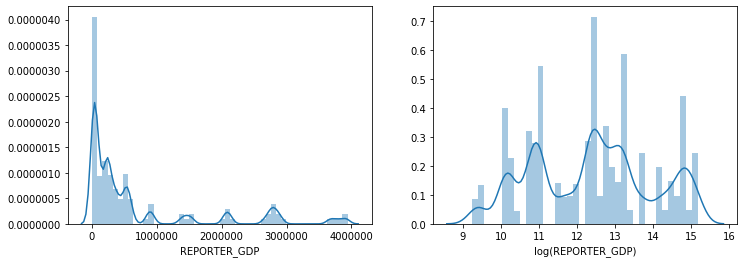

In [209]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(vizdf["REPORTER_GDP"])
plt.xlabel("REPORTER_GDP")
plt.subplot(1,2,2)
sns.distplot(vizdf["REPORTER_GDP"].apply(np.log))
plt.xlabel("log(REPORTER_GDP)")
plt.show()

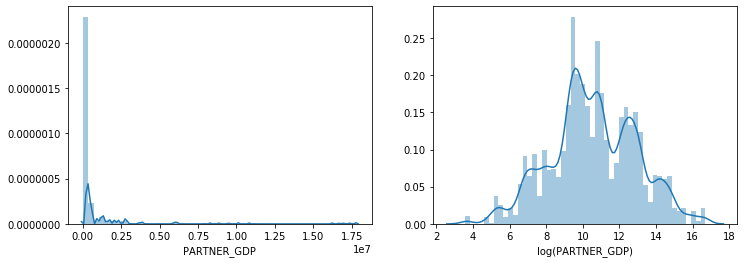

In [210]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(vizdf["PARTNER_GDP"])
plt.xlabel("PARTNER_GDP")
plt.subplot(1,2,2)
sns.distplot(vizdf["PARTNER_GDP"].apply(np.log))
plt.xlabel("log(PARTNER_GDP)")
plt.show()

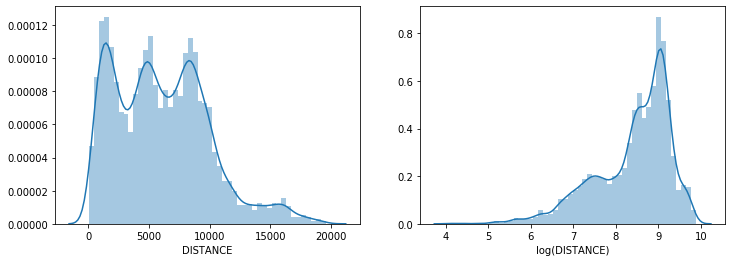

In [211]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(vizdf["DISTANCE"])
plt.xlabel("DISTANCE")
plt.subplot(1,2,2)
sns.distplot(vizdf["DISTANCE"].apply(np.log))
plt.xlabel("log(DISTANCE)")
plt.show()

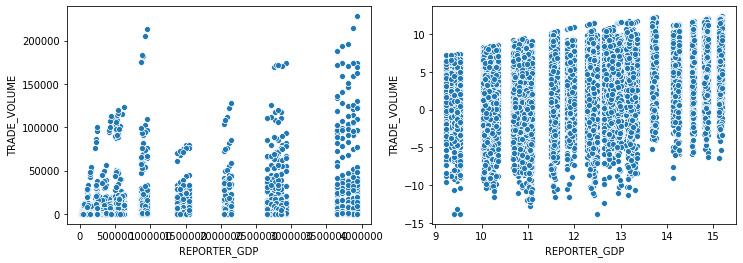

In [212]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=vizdf["REPORTER_GDP"], y=vizdf["TRADE_VOLUME"]);
plt.subplot(1,2,2)
sns.scatterplot(x=vizdf["REPORTER_GDP"].apply(np.log), y=vizdf["TRADE_VOLUME"].apply(np.log));
plt.show()

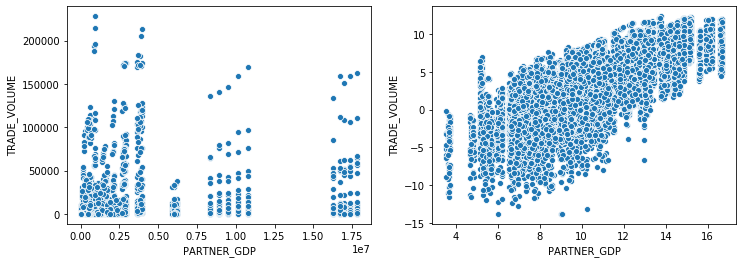

In [213]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=vizdf["PARTNER_GDP"], y=vizdf["TRADE_VOLUME"]);
plt.subplot(1,2,2)
sns.scatterplot(x=vizdf["PARTNER_GDP"].apply(np.log), y=vizdf["TRADE_VOLUME"].apply(np.log));
plt.show()

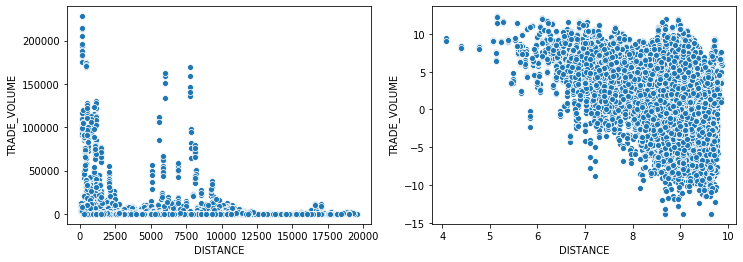

In [214]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=vizdf["DISTANCE"], y=vizdf["TRADE_VOLUME"]);
plt.subplot(1,2,2)
sns.scatterplot(x=vizdf["DISTANCE"].apply(np.log), y=vizdf["TRADE_VOLUME"].apply(np.log));
plt.show()

## Estimate gravity model

In [364]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [216]:
def lr_summary(lr_model, features):
    '''Prints out linear regression summary statistics'''
    print("MODEL SUMMARY")
    print()
    print(pd.DataFrame({
        "Features": features + ["constant"],
        "Coefficients": list(lr_model.coefficients) + [lr_model.intercept],
        "Standard errors": lr_model.summary.coefficientStandardErrors,
        "t-Values": lr_model.summary.tValues,
        "p-Values": lr_model.summary.pValues
    }))
    print()
    print("RMSE:               {:.6f}".format(lr_model.summary.rootMeanSquaredError))
    print("R2:                 {:.6f}".format(lr_model.summary.r2))
    print("Explained variance: {:.6f}".format(lr_model.summary.explainedVariance))

### Basic gravity equation for 2018

# TO DO: Filter out other years!

Estimated equation: $$ ln(TradeVolume_{ij}) = \beta_0 + \beta_1ln(GDP_i) + \beta_2ln(GDP_j) + \beta_3ln(Distance_{ij}) + \varepsilon_{ij} $$

In [217]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE
0,NL,MK,2014,E,140.318079,8.618161e+05,1.022170e+04,1694.944,1,0,0
1,DE,HN,2014,E,433.835640,3.654924e+06,1.801671e+04,9083.054,0,0,0
2,DE,AR,2014,E,3686.134307,3.654924e+06,4.437071e+05,11512.140,0,0,0
3,IT,CG,2014,E,965.454652,2.043486e+06,1.423810e+04,5140.217,0,0,0
4,IT,US,2014,E,42101.902882,2.043486e+06,1.624253e+07,6895.107,0,0,0


In [218]:
# log transform for trade volume, reporter gdp, partner gpd, distance

data = data \
    .withColumn("TRADE_VOLUME_log", F.log(df.TRADE_VOLUME)) \
    .withColumn("REPORTER_GDP_log", F.log(df.REPORTER_GDP)) \
    .withColumn("PARTNER_GDP_log", F.log(df.PARTNER_GDP)) \
    .withColumn("DISTANCE_log", F.log(df.DISTANCE))

# TO DO: add log transform to pipeline with custom transformer

In [223]:
# Vector Assembler
features = ["REPORTER_GDP_log", "PARTNER_GDP_log", "DISTANCE_log"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [224]:
# Regression model
model = LinearRegression(maxIter=100,
                         labelCol='TRADE_VOLUME_log', 
                         featuresCol='features')

# If LinearRegression.fitIntercept is set to true, then the last element returned corresponds to the intercept.

In [225]:
# Define pipeline
pipeline = Pipeline(stages=[assembler, model])

In [226]:
# Execute pipeline
fitted_pipeline = pipeline.fit(data)

In [227]:
# Extract trained model from fitted pipeline
trained_model = fitted_pipeline.stages[-1]

In [228]:
# Print out model summary
lr_summary(lr_model=trained_model, features=features)

MODEL SUMMARY

           Features  Coefficients  Standard errors    t-Values  p-Values
0  REPORTER_GDP_log      1.156082         0.007004  165.059224       0.0
1   PARTNER_GDP_log      1.083575         0.004913  220.561375       0.0
2      DISTANCE_log     -1.251136         0.012995  -96.277788       0.0
3          constant    -12.095171         0.159846  -75.667425       0.0

RMSE:               1.692047
R2:                 0.806576
Explained variance: 11.938779


### Training a more complex model

Estimated equation: $$ ln(TradeVolume_{ij}) = \beta_0 + \beta_1ln(GDP_i) + \beta_2ln(GDP_j) + \beta_3ln(Distance_{ij}) + \varepsilon_{ij} $$ + *landlocked etc*

In [229]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log
0,NL,MK,2014,E,140.318079,8.618161e+05,1.022170e+04,1694.944,1,0,0,4.943912,13.666797,9.232268,7.435405
1,DE,HN,2014,E,433.835640,3.654924e+06,1.801671e+04,9083.054,0,0,0,6.072666,15.111586,9.799055,9.114166
2,DE,AR,2014,E,3686.134307,3.654924e+06,4.437071e+05,11512.140,0,0,0,8.212334,15.111586,13.002920,9.351157
3,IT,CG,2014,E,965.454652,2.043486e+06,1.423810e+04,5140.217,0,0,0,6.872599,14.530168,9.563677,8.544851
4,IT,US,2014,E,42101.902882,2.043486e+06,1.624253e+07,6895.107,0,0,0,10.647848,14.530168,16.603143,8.838567


In [230]:
# String Indexer
# trade type: I = internal (within the EU), E = external
stringindexer = StringIndexer(
    inputCol="TRADE_TYPE",
    outputCol="TRADE_TYPE_index"
)

In [231]:
# Vector Assembler
features = [
    "REPORTER_GDP_log", 
    "PARTNER_GDP_log", 
    "DISTANCE_log", 
    "LANDLOCKED_ANY", 
    "COMMON_BORDER", 
    "COMMON_LANGUAGE", 
    "TRADE_TYPE_index"
]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [232]:
# Regression model
model = LinearRegression(maxIter=100,
                         labelCol='TRADE_VOLUME_log', 
                         featuresCol='features',
                         fitIntercept=True)

# If LinearRegression.fitIntercept is set to true, then the last element returned corresponds to the intercept.

In [233]:
# Define pipeline
pipeline = Pipeline(stages=[stringindexer, assembler, model])

In [234]:
# Execute pipeline
fitted_pipeline = pipeline.fit(data)

In [235]:
# Extract trained model from fitted pipeline
trained_model = fitted_pipeline.stages[-1]

In [236]:
# Print out model summary
lr_summary(lr_model=trained_model, features=features)

MODEL SUMMARY

           Features  Coefficients  Standard errors    t-Values  p-Values
0  REPORTER_GDP_log      1.129983         0.006869  164.505677  0.000000
1   PARTNER_GDP_log      1.062890         0.004893  217.236081  0.000000
2      DISTANCE_log     -1.115141         0.016891  -66.020392  0.000000
3    LANDLOCKED_ANY     -0.582429         0.022829  -25.513097  0.000000
4     COMMON_BORDER      0.392470         0.084907    4.622339  0.000004
5   COMMON_LANGUAGE      0.753650         0.044465   16.949380  0.000000
6  TRADE_TYPE_index      0.603661         0.039951   15.109886  0.000000
7          constant    -12.642528         0.181487  -69.660913  0.000000

RMSE:               1.648381
R2:                 0.816430
Explained variance: 12.084643


### treating this as prediction task

* doesn't make much logical sense in this context but still, if you have the data...



https://spark.apache.org/docs/latest/ml-features#standardscaler

In [344]:
# train/test split
data_train, data_test = data.randomSplit([0.8,0.2])

In [345]:
# String Indexer
# trade type: I = internal (within the EU), E = external
stringindexer = StringIndexer(
    inputCol="TRADE_TYPE",
    outputCol="TRADE_TYPE_index"
)

In [346]:
# Vector Assembler
features = [
    "REPORTER_GDP_log", 
    "PARTNER_GDP_log", 
    "DISTANCE_log", 
    "LANDLOCKED_ANY", 
    "COMMON_BORDER", 
    "COMMON_LANGUAGE", 
    "TRADE_TYPE_index"
]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [347]:
# MinMax scaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [350]:
# Regression model
lr = LinearRegression(
    maxIter=100,
    labelCol='TRADE_VOLUME_log', 
    featuresCol='features',
    fitIntercept=True)

In [351]:
# Define pipeline
pipeline = Pipeline(stages=[stringindexer, assembler, scaler, lr])

In [369]:
# Tune grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10,50,100]) \
    .addGrid(lr.regParam, [0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .build()

In [370]:
# Evaluator
evaluator = RegressionEvaluator(
    labelCol='TRADE_VOLUME_log', 
    predictionCol='prediction', 
    metricName='rmse')

In [371]:
# Cross validator
crossvalidator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3)

In [372]:
model = crossvalidator.fit(data_train)

In [375]:
trained_lr = model.bestModel.stages[-1]
trained_lr

LinearRegression_662fec805bf4

In [376]:
lr_summary(trained_lr, features=features)

MODEL SUMMARY

           Features  Coefficients  Standard errors    t-Values      p-Values
0  REPORTER_GDP_log      1.101073         0.007605  144.773272  0.000000e+00
1   PARTNER_GDP_log      1.036793         0.005412  191.575610  0.000000e+00
2      DISTANCE_log     -1.082674         0.018348  -59.008696  0.000000e+00
3    LANDLOCKED_ANY     -0.574106         0.025322  -22.672379  0.000000e+00
4     COMMON_BORDER      0.477346         0.095290    5.009404  5.509096e-07
5   COMMON_LANGUAGE      0.751417         0.048817   15.392592  0.000000e+00
6  TRADE_TYPE_index      0.683052         0.043454   15.719049  0.000000e+00
7          constant    -12.295342         0.197780  -62.166686  0.000000e+00

RMSE:               1.656151
R2:                 0.815179
Explained variance: 11.578591


In [377]:
print('maxIter:', trained_lr._java_obj.getMaxIter())
print('elasticNetParam:', trained_lr._java_obj.getElasticNetParam())
print('regParam:', trained_lr._java_obj.getRegParam())

maxIter: 10
elasticNetParam: 0.0
regParam: 0.1


In [378]:
# predictions

In [379]:
# training data
predictions = model.transform(data_train)
evaluator.evaluate(predictions)

1.6561510539878925

In [380]:
# test data
predictions = model.transform(data_test)
evaluator.evaluate(predictions)

1.6258705323576124

In [382]:
predictions.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log,TRADE_TYPE_index,features,scaledFeatures,prediction
0,AT,DK,2015,I,1317.254393,413554.595891,343294.474736,868.5304,1,0,0,7.183305,12.932545,12.746344,6.766803,1.0,"[12.932544818324901, 12.746343884751296, 6.766...","[0.6208452825767835, 0.6994512357343458, 0.462...",7.942356
1,AT,GL,2016,E,0.336851,421989.351972,2695.471275,4316.9810,1,0,0,-1.088115,12.952735,7.899328,8.370312,0.0,"[12.952735360406221, 7.899328338334872, 8.3703...","[0.6242416927713413, 0.3307293762179352, 0.739...",0.520105
2,BE,MK,2015,E,255.984169,509300.652082,10615.805819,1634.0220,1,0,0,5.545116,13.140794,9.270099,7.398800,0.0,"[13.140793793222299, 9.270099284455757, 7.3987...","[0.6558764837450837, 0.43500657677250065, 0.57...",3.200208
3,BE,NG,2016,E,2016.967185,516698.510032,456775.408620,4940.5090,0,0,0,7.609350,13.155215,13.031947,8.505224,0.0,"(13.155214830647278, 13.03194710185457, 8.5052...","[0.6583023600949621, 0.7211776255686112, 0.762...",6.492553
4,BG,BA,2018,E,83.075494,60767.158522,20130.528205,416.3402,0,0,0,4.419750,11.014805,9.909993,6.031503,0.0,"(11.014804766124866, 9.9099927579707, 6.031502...","[0.2982471156939682, 0.48368451254295347, 0.33...",3.577219
